### 0. Importación de librerías y carga de datos

In [1]:
# Librerías para manejo de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Composicion de pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split

# Regresion lineal
from sklearn.linear_model import LinearRegression

# Importar/ Exportar modelos
from joblib import dump, load

# Metricas
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# q-q plots
import scipy.stats as stats

# Para sacar un reporte estadístico que podemos usar para determinar las importancia de las variables explicativas.
import statsmodels.api as sm 

In [2]:
# Se cargan los datos
# Ubicación de los datos, deben estar en la misma carpeta que este notebook
pais = "espana"
liga = "laliga-smartbank"

file = open(f"versiones/{pais}_{liga}.txt", "r")
version = int(file.read())-1
file.close()

db_location = f"data/{pais}_{liga}/version{version}/resultados_anteriores.csv"

# Se leen los datos, estan separados con ','
data = pd.read_csv(db_location, sep=',', encoding = 'utf-8', na_values = '-')

### 1. Entendimiento de los datos

In [3]:
# Se revisa la forma general de los datos cargados
data.shape

(219, 42)

In [4]:
# Se muestra una pequeña muestra de los datos
data.head()

,Date,HomeTeam,AwayTeam,HG,AG,HP,AP,HTS,ATS,HSI,...,ATP,HPC,APC,HT,AT,HA,AA,HDA,ADA,Resultado
0,11.12.2022 15:00,Las Palmas,Albacete,1,2,69%,31%,25,12,11,...,244,484,161,20,22,122,70,58,38,-1
1,11.12.2022 15:00,Racing,Mirandés,1,2,54%,46%,12,6,5,...,366,308,271,19,25,112,99,63,20,-1
2,11.12.2022 12:30,Eibar,Real Oviedo,1,0,62%,38%,9,9,2,...,358,468,227,11,19,149,113,60,29,1
3,11.12.2022 12:30,Granada,Burgos CF,1,0,56%,44%,14,11,4,...,327,343,242,12,10,89,75,50,46,1
4,11.12.2022 10:15,Ponferradina,Lugo,1,0,46%,54%,10,4,3,...,456,292,342,13,19,102,118,36,47,1


In [5]:
# Se imprimen los diferentes tipos de las columnas. Todas son numéricas
data.dtypes

Date          object
HomeTeam      object
AwayTeam      object
HG             int64
AG             int64
HP            object
AP            object
HTS            int64
ATS            int64
HSI            int64
ASI            int64
HSO            int64
ASO            int64
HBS            int64
ABS            int64
HFK            int64
AFK            int64
HC             int64
AC             int64
HOFF           int64
AOFF           int64
HTI            int64
ATI            int64
HGS            int64
AGS            int64
HF             int64
AF             int64
HRC          float64
ARC          float64
HYC          float64
AYC          float64
HTP            int64
ATP            int64
HPC            int64
APC            int64
HT             int64
AT             int64
HA             int64
AA             int64
HDA            int64
ADA            int64
Resultado      int64
dtype: object

In [6]:
# Se hace una decripción de los datos
data.describe()

,HG,AG,HTS,ATS,HSI,ASI,HSO,ASO,HBS,ABS,...,ATP,HPC,APC,HT,AT,HA,AA,HDA,ADA,Resultado
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,1.164384,0.785388,12.356164,9.890411,4.187215,2.894977,5.228311,4.502283,2.940639,2.493151,...,383.210046,324.712329,295.643836,15.324201,16.004566,104.662100,94.164384,46.479452,38.598174,0.378995
std,1.049426,0.842978,4.619573,4.148267,2.136752,1.872770,2.639315,2.466983,2.163318,1.966158,...,114.744597,117.290138,115.777195,4.675714,5.020598,22.094563,20.788150,15.820185,14.239214,1.280667
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,156.000000,76.000000,90.000000,4.000000,3.000000,46.000000,52.000000,11.000000,9.000000,-4.000000
25%,0.000000,0.000000,9.000000,7.000000,3.000000,1.000000,3.000000,3.000000,1.000000,1.000000,...,309.000000,242.000000,226.000000,12.000000,12.000000,90.000000,79.500000,37.000000,29.000000,0.000000
50%,1.000000,1.000000,12.000000,10.000000,4.000000,3.000000,5.000000,4.000000,2.000000,2.000000,...,363.000000,309.000000,278.000000,15.000000,16.000000,103.000000,92.000000,44.000000,37.000000,0.000000
75%,2.000000,1.000000,15.000000,12.000000,5.000000,4.000000,7.000000,6.000000,4.000000,3.500000,...,452.500000,401.000000,356.500000,18.000000,19.000000,122.000000,105.000000,54.000000,45.000000,1.000000
max,5.000000,4.000000,26.000000,26.000000,11.000000,9.000000,14.000000,12.000000,11.000000,13.000000,...,826.000000,737.000000,748.000000,30.000000,38.000000,167.000000,164.000000,126.000000,131.000000,5.000000


In [7]:
# Se observa que no existen valores nulos en las variables
data.isnull().sum()

Date           0
HomeTeam       0
AwayTeam       0
HG             0
AG             0
HP             0
AP             0
HTS            0
ATS            0
HSI            0
ASI            0
HSO            0
ASO            0
HBS            0
ABS            0
HFK            0
AFK            0
HC             0
AC             0
HOFF           0
AOFF           0
HTI            0
ATI            0
HGS            0
AGS            0
HF             0
AF             0
HRC          158
ARC          158
HYC            4
AYC            4
HTP            0
ATP            0
HPC            0
APC            0
HT             0
AT             0
HA             0
AA             0
HDA            0
ADA            0
Resultado      0
dtype: int64

### 2. Identificación de variables a utilizar

<AxesSubplot:>

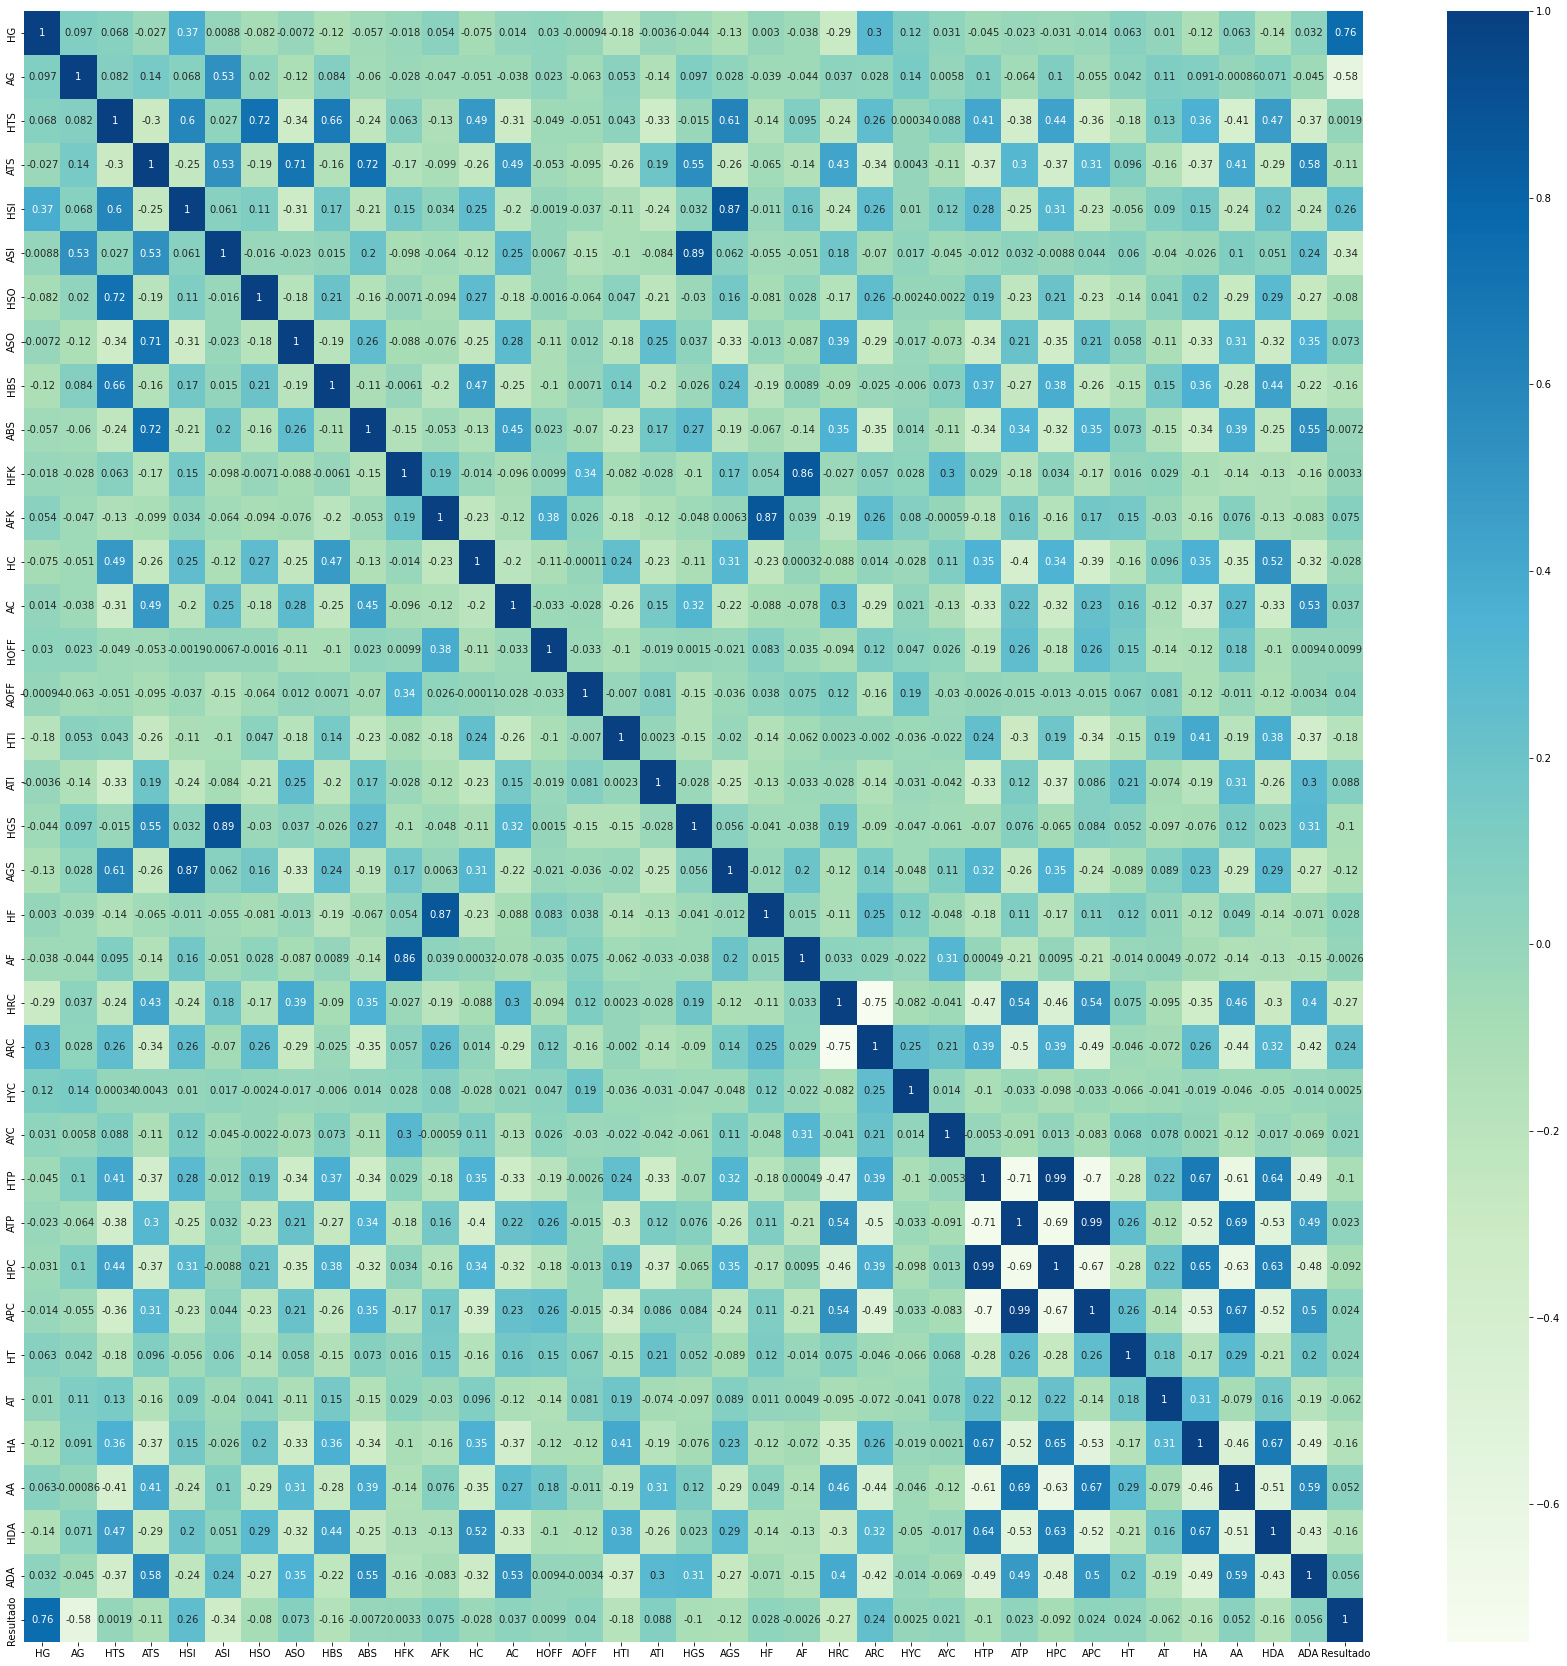

In [8]:
# Se revisa si la variable objetivo está correlacionada con otra variable
plt.figure(figsize =(30,30))
correlacion = data.corr()
sns.heatmap(correlacion, cmap = 'GnBu', annot = True)

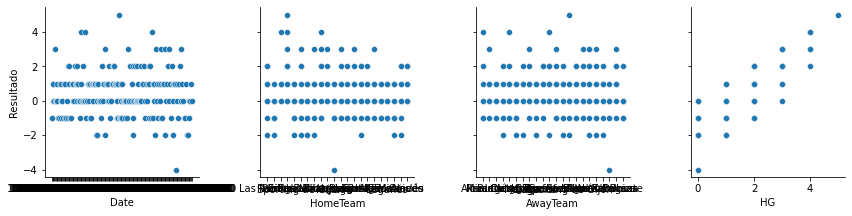

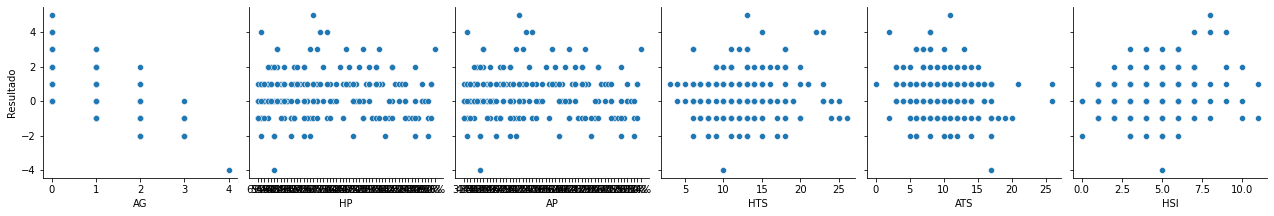

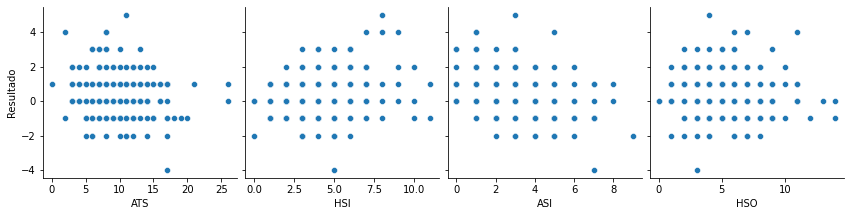

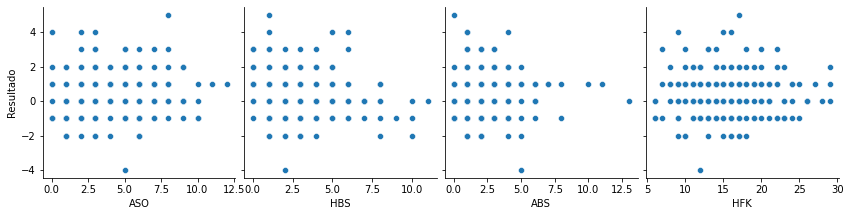

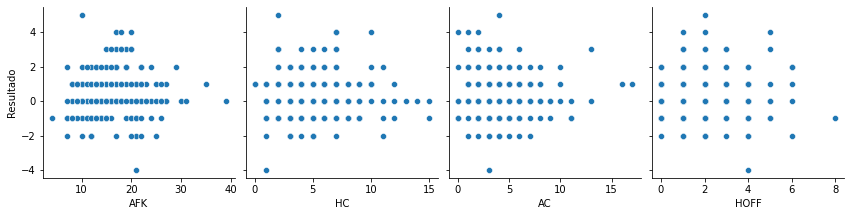

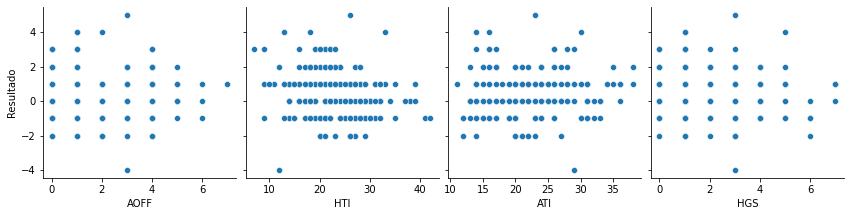

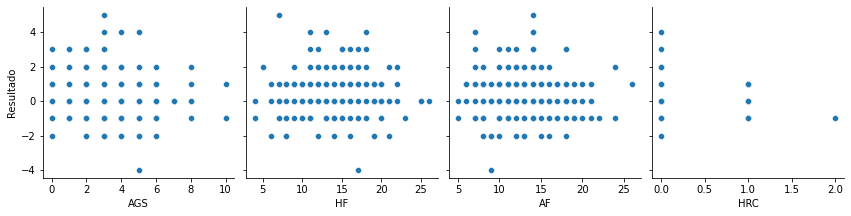

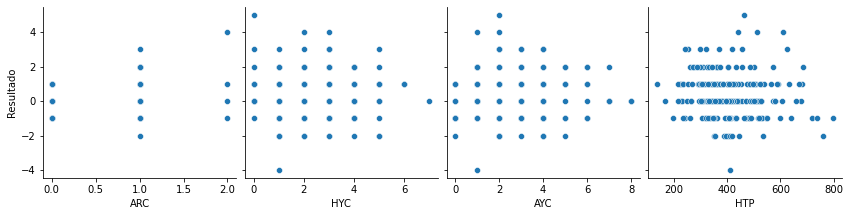

In [9]:
# Se diagrama la relación entre cada variable explicativa y la variable objetivo
sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[0:4], kind='scatter')
sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[4:10], kind='scatter')
sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[8:12], kind='scatter')
sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[12:16], kind='scatter')
sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[16:20], kind='scatter')
sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[20:24], kind='scatter')
sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[24:28], kind='scatter')
sns.pairplot(data, height=3, y_vars = 'Resultado', x_vars = data.columns[28:32], kind='scatter')

In [10]:
selected_cols = ['HTS', 'ATS', 'HSI', 'ASI', 'HSO', 'ASO', 'HBS', 'ABS', 'HGS', 'AGS']
selected_cols2 = ['HP', 'AP', 'HC', 'AC', 'HOFF', 'AOFF', 'HF', 'AF',
                    'HYC', 'AYC', 'HTP', 'ATP', 'HT', 'AT', 'HA', 'AA', 'HDA', 'ADA']

### 3. Limpieza y preparación de datos

In [11]:
# los pasos de limpieza y preparación se realizan sobre otro archivo
df_data = data.copy()[selected_cols]
df_data.insert(0, "Resultado", data["Resultado"])

In [12]:
df_data.head()

,Resultado,HTS,ATS,HSI,ASI,HSO,ASO,HBS,ABS,HGS,AGS
0,-1,25,12,11,7,7,3,7,2,5,10
1,-1,12,6,5,4,5,0,2,2,2,4
2,1,9,9,2,0,3,5,4,4,0,1
3,1,14,11,4,5,7,5,3,1,5,3
4,1,10,4,3,1,4,2,3,1,1,2


In [13]:
#def convert_possession(value):
#    value2 = str(value)  # cast to string
#    value3 = value2[:-1] # last four characters
#    return int(value3) if len(value3) > 0 else 50

#df_data['HP'] = df_data['HP'].apply(convert_possession)
#df_data['AP'] = df_data['AP'].apply(convert_possession)

In [14]:
#def convert_yellow_cards(value):
#    return int(value)

#df_data['HYC'] = df_data['HYC'].fillna(0)
#df_data['AYC'] = df_data['AYC'].fillna(0)
#df_data['HYC'] = df_data['HYC'].apply(convert_yellow_cards)
#df_data['AYC'] = df_data['AYC'].apply(convert_yellow_cards)

In [15]:
df_data.head()

,Resultado,HTS,ATS,HSI,ASI,HSO,ASO,HBS,ABS,HGS,AGS
0,-1,25,12,11,7,7,3,7,2,5,10
1,-1,12,6,5,4,5,0,2,2,2,4
2,1,9,9,2,0,3,5,4,4,0,1
3,1,14,11,4,5,7,5,3,1,5,3
4,1,10,4,3,1,4,2,3,1,1,2


### 4. Modelamiento

#### Pipeline 1: solo con selección de variables

In [16]:
# Se usa un transformador para seleccionar unicamente las columnas que se quieren usar
pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols)])),]
# Se declara el modelo
model = [('model', LinearRegression())]
# Se declara el pipeline
pipeline1 = Pipeline(pre+model)

In [17]:
# Se extraen las variables explicativas y objetivo para entrenar
df_datap1 = df_data

X = df_datap1.drop('Resultado', axis = 1)
Y = df_datap1['Resultado']

# Se realiza la división entrenamiento - test. Se deja 20% de los datos para el test.
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=0)

# Se entrena el modelo
pipeline1 = pipeline1.fit(X_train,Y_train)

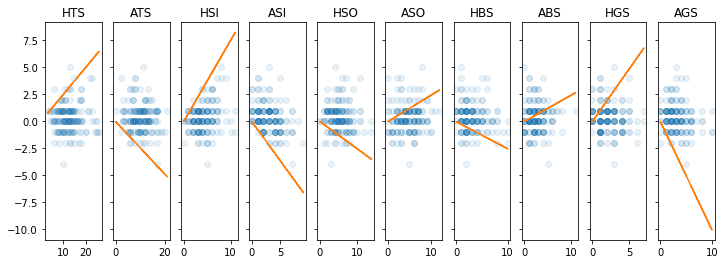

In [18]:
# Se visualiza la regresion lineal en cada dimension
f, axs = plt.subplots(1, len(selected_cols), sharey=True, figsize = (12,4))

for i in range(len(selected_cols)):
    pos_col = i
    col = selected_cols[pos_col]

    # Variable x
    x = X_train[col]
    # Pendiente
    m = pipeline1['model'].coef_[pos_col]
    # Interceto
    b = pipeline1['model'].intercept_

    axs[i].plot(x, Y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x*m + b)
    axs[i].set_title(col)

In [19]:
# Vale la pena hacer estandarización de los datos para tener coeficientes más comparables en misma escala.
importancia = pipeline1['model'].coef_
pd.options.display.float_format = '{:.5f}'.format
importancia_atributo = pd.DataFrame(data={"Atributo": selected_cols,"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo

,Atributo,Importancia
0,HGS,0.97340
1,HSI,0.75262
2,HTS,0.25077
3,ABS,0.24419
4,ASO,0.24401
5,ATS,-0.24363
6,HSO,-0.24931
7,HBS,-0.25254
8,ASI,-0.73184
9,AGS,-1.00445


In [20]:
# Se obtienen las predicciones del modelo sobre el conjunto de entrenamiento.
y_pred = pipeline1.predict(X_train)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("Estadísticas Pipeline #1 - Datos de entrenamiento")
print("RMSE: %.2f" % np.sqrt(mse(Y_train, y_pred)))
print('R²: %.2f' % r2_score(Y_train, y_pred))

Estadísticas Pipeline #1 - Datos de entrenamiento
RMSE: 0.10
R²: 0.99


In [21]:
# Se obtienen las predicciones del modelo sobre el conjunto de test.
y_pred = pipeline1.predict(X_test)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("Estadísticas Pipeline #1 - Datos de test")
print("RMSE: %.2f" % np.sqrt(mse(Y_test, y_pred)))
print('R²: %.2f' % r2_score(Y_test, y_pred))

Estadísticas Pipeline #1 - Datos de test
RMSE: 0.02
R²: 1.00


<AxesSubplot:>

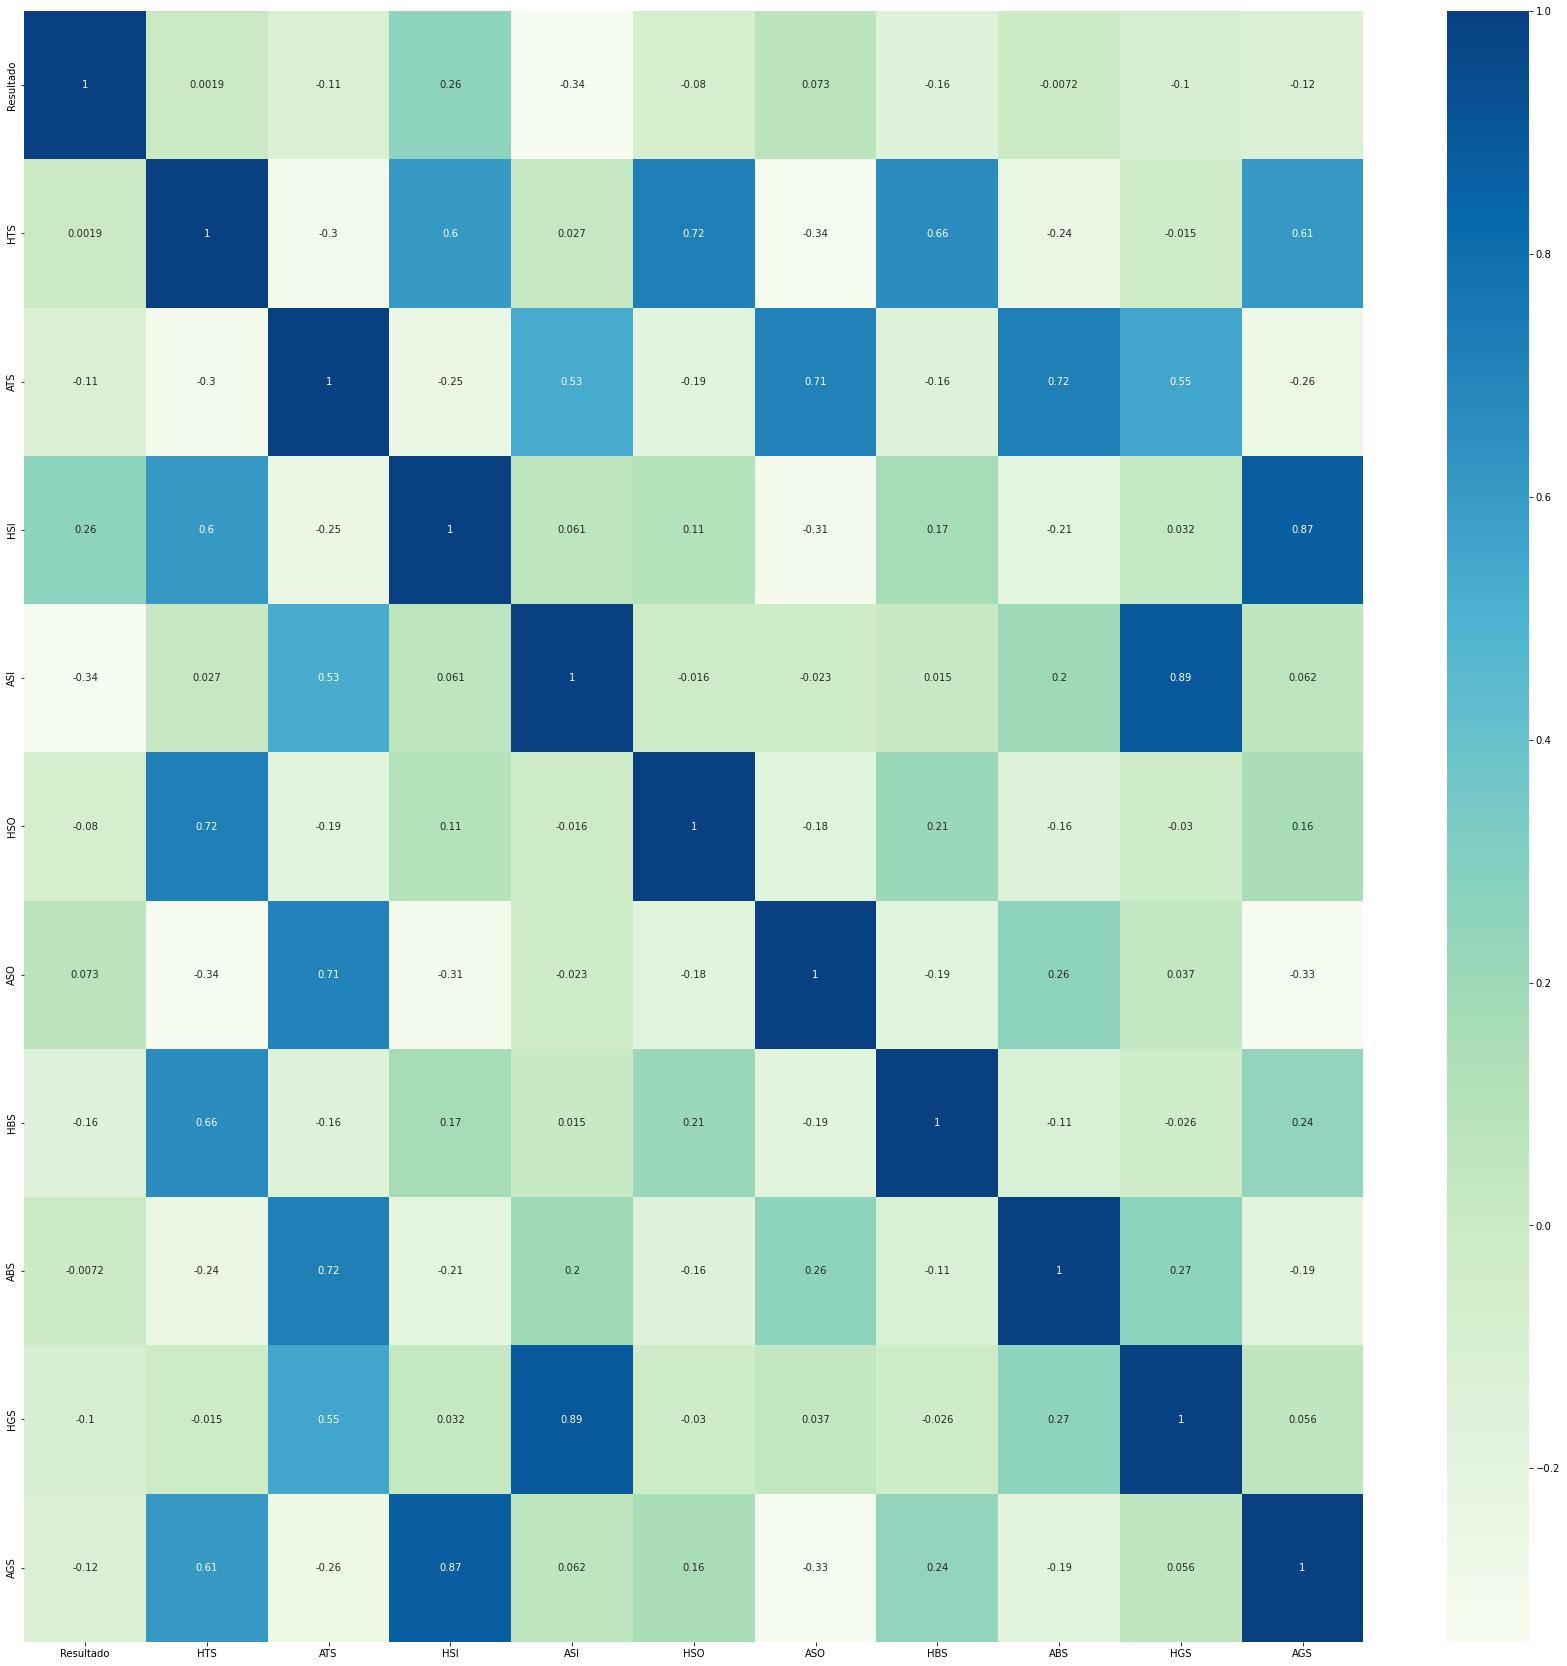

In [22]:
# Se revisa la colinealidad
df_temp = df_datap1[selected_cols]
plt.figure(figsize =(30,30))
correlacion = df_datap1.corr()
sns.heatmap(correlacion, cmap = 'GnBu', annot = True)

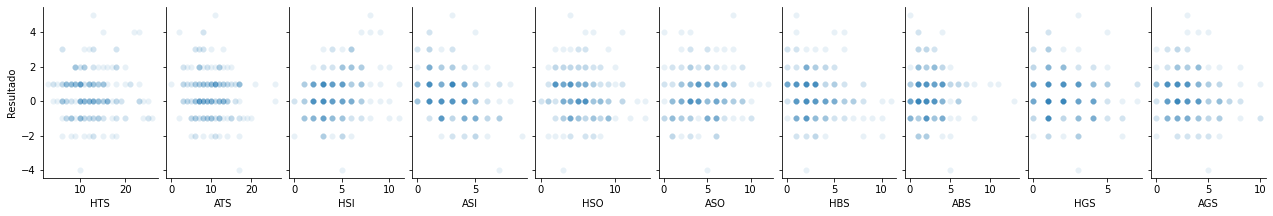

In [23]:
# Linealidad
#Se ven datos relativamente juntos, sin embargo, hay una pequeña cantidad de datos fuera de esta cohesión en las tres variables.
sns.pairplot(df_datap1, height=3, aspect = 0.6, y_vars = 'Resultado', x_vars = selected_cols, kind='scatter', plot_kws = {'alpha':0.1})

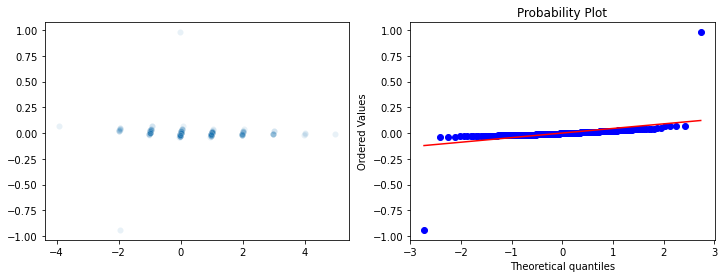

In [24]:
# Nos sirve para revisar si los errores vienen con una distribución teoríca. En este caso, de una distribución normal.
X = df_data.drop('Resultado', axis = 1)
y = df_data['Resultado']

# Calculamos los errores
errors = (pipeline1.predict(X) - y).values

fig, axes = plt.subplots(1, 2, figsize = (12,4))

# Dispersión
sns.scatterplot(x = pipeline1.predict(X), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

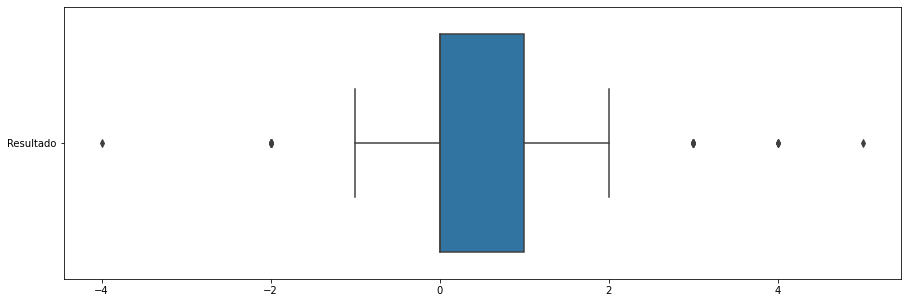

In [25]:
# Diagrama de caja
# Acá podemos ver los valores atípicos de Life expectancy.
# En este caso están los menores a 44.5.
fig=plt.figure(figsize=(15,5))
ax = sns.boxplot(data= df_datap1[['Resultado']], orient="h")

#### Pipeline 2: Modelo con eliminación de valores atípicos en la variable objetivo y estandarización

In [26]:
# Se eliminan los valores atípicos que indica el diagrama de caja.
df_datap2 = df_data
#df_datap2 = df_datap2.drop(df_datap2[df_datap2['Resultado'] < -2].index)
#df_datap2 = df_datap2.drop(df_datap2[df_datap2['Resultado'] > 2].index)

In [27]:
# Se declara el modelo
model2 = [('model2', LinearRegression())]

#Pre
pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols)])),
       ('scaler', StandardScaler()),]

# Se declara el pipeline
pipeline2 = Pipeline(pre+model2)

# Se extraen las variables explicativas y objetivo para entrenar
X = df_datap2.drop('Resultado', axis = 1)
Y = df_datap2['Resultado']

# Se realiza la división entrenamiento - test. Se deja 20% de los datos para el test.
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=0)

# Se entrena el modelo
pipeline2 = pipeline2.fit(X_train,Y_train)

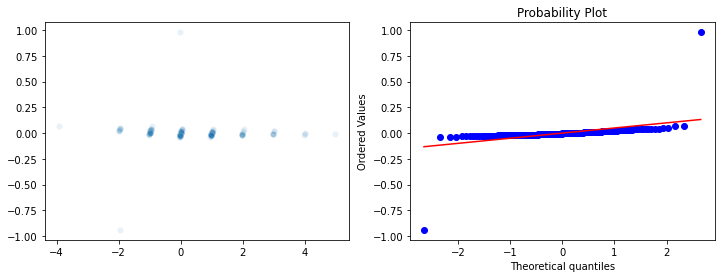

In [28]:
# Se calculan los errores
errors = (pipeline2.predict(X_train) - Y_train).values

fig, axes = plt.subplots(1, 2, figsize = (12,4))

# Dispersión
sns.scatterplot(x = pipeline2.predict(X_train), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

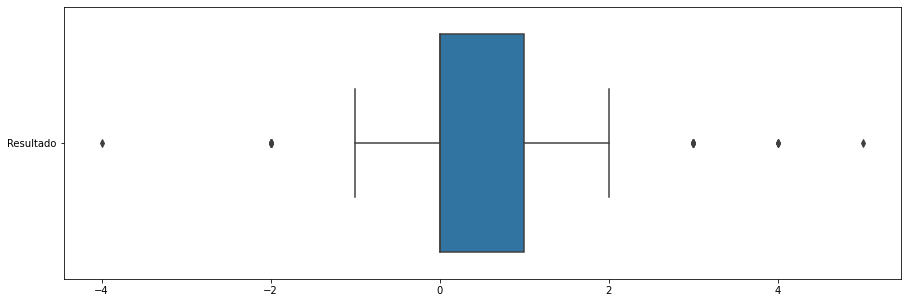

In [29]:
# Diagrama de caja
# Se ve que los datos ya están eliminados
fig=plt.figure(figsize=(15,5))
ax = sns.boxplot(data= df_datap2[['Resultado']], orient="h")

In [30]:
# Se obtienen las predicciones del modelo sobre el conjunto de entrenamiento.
y_pred = pipeline2.predict(X_train)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("Estadísticas Pipeline #2 - Datos de entrenamiento")
print("RMSE: %.2f" % np.sqrt(mse(Y_train, y_pred)))
print('R²: %.2f' % r2_score(Y_train, y_pred))

Estadísticas Pipeline #2 - Datos de entrenamiento
RMSE: 0.10
R²: 0.99


In [31]:
# Se obtienen las predicciones del modelo sobre el conjunto de test.
y_pred = pipeline2.predict(X_test)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("Estadísticas Pipeline #2 - Datos de test")
print("RMSE: %.2f" % np.sqrt(mse(Y_test, y_pred)))
print('R²: %.2f' % r2_score(Y_test, y_pred))

Estadísticas Pipeline #2 - Datos de test
RMSE: 0.02
R²: 1.00


### 5. Evaluación cuantitativa

In [32]:
# Se ajusta el modelo para ver el reporte de estadísticas
model = sm.OLS(Y, X).fit()
# Se muestran las estadísticas del modelo
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Resultado   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              5267.
Date:                Tue, 27 Dec 2022   Prob (F-statistic):                   2.48e-238
Time:                        09:14:06   Log-Likelihood:                          206.88
No. Observations:                 219   AIC:                                     -397.8
Df Residuals:                     211   BIC:                                     -370.7
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HTS            0.2498      0.002    154.499      0.000       0.247       0.253
ATS           -0.2454      0.002   -117.395      0.000      -0.250      -0.241
HSI            0.7511      0.005    164.783      0.000       0.742       0.760
ASI           -0.7357      0.006   -125.611      0.000      -0.747      -0.724
HSO           -0.2495      0.003    -93.097      0.000      -0.255      -0.244
ASO            0.2449      0.003     81.650      0.000       0.239       0.251
HBS           -0.2518      0.003    -87.029      0.000      -0.257      -0.246
ABS            0.2453      0.003     70.362      0.000       0.238       0.252
HGS            0.9795      0.009    104.455      0.000       0.961       0.998
AGS           -1.0027      0.007   -145.134      0.000      -1.016      -0.989
==============================================================================
Omnibus:                      128.053   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91505.245
Skew:                          -0.611   Prob(JB):                         0.00
Kurtosis:                     103.132   Cond. No.                     7.20e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.57e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [33]:
# Se guarda el pipeline en el archivo
filename = 'model/modelo.joblib' # Ubicación del archivo a entregar
dump(pipeline2, filename)

['model/modelo.joblib']

In [34]:
# Proceso de prueba del cliente
df_recent = pd.read_csv(f"data/{pais}_{liga}/version{version}/proximos_partidos.csv", sep=',', encoding = 'utf-8', na_values = '-') # Lectura de los datos recientes

# Se lee el archivo y carga el modelo
pipeline = load(filename)

y_predicted = pipeline.predict(df_recent)

In [35]:
for i in y_predicted:
    print ("{:.2f}".format(i))

-0.75
1.21
1.47
1.26
1.31
2.22
-0.09
-0.33
0.66
0.20
3.16
-2.38
-0.20
0.39
-2.37
2.88
3.34
0.26
-1.27
0.42
1.71
-0.31
-4.17
0.41
2.48
-0.39
0.21
1.59
0.29
2.69
0.19
0.47
0.19
-0.89
-0.92
-0.28
3.18
-0.20
-1.01
2.89
-1.21
0.07
2.65
-1.30
-0.78
-1.59
-0.87
0.52
2.88
1.79
2.87
2.27
-0.59
-0.69
0.98
-2.20
-1.33
0.60
0.49
1.47
-1.10
-0.18
-0.35
2.74
-0.89
-1.66
3.30
0.17
-1.38
1.41
0.71
1.59
1.88
0.10
-0.09
0.92
1.40
-1.32
-0.66
2.79
-2.40
2.58
-0.20
-0.37
-1.02
0.47
-0.73
1.41
1.22
-1.73
0.11
0.30
1.78
-0.39
0.89
1.38
-3.16
0.42
2.10
-0.21
0.60
2.61
1.57
-2.12
-1.11
-1.62
1.47
2.46
-1.70
-0.18
2.90
-1.92
2.29
0.61
-0.39
2.47
-1.28
1.57
0.60
-1.06
1.41
-0.70
1.49
1.87
0.68
-3.29
-0.10
-0.61
1.64
0.78
0.79
1.23
0.41
0.95
0.31
0.41
0.81
2.90
1.17
0.29
0.56
-2.65
-0.21
2.39
0.41
2.36
-0.51
-0.60
-2.18
-0.40
-0.54
1.45
-1.68
2.31
0.91
0.06
2.49
-0.41
-1.10
2.98
1.26
-1.19
-1.49
1.32
-0.20
1.97
-1.00
2.78
-0.44
0.54
-0.69
1.79
0.66
-2.28
-0.76
1.91
0.49
-1.22
2.50
-1.58
-0.41
1.88
0.15
2.37
0.09

In [36]:
for i in range(len(y_predicted)):
    home_team = df_recent.iloc[i]["HomeTeam"]
    away_team = df_recent.iloc[i]["AwayTeam"]
    
    print(home_team + " vs " + away_team)
    print(y_predicted[i])
    ganador = home_team if y_predicted[i] >= 0.5 else (away_team if y_predicted[i] <= -0.5 else "ninguno")
    if ganador == "ninguno":
            print("No hay ganador claro. " + str(abs(y_predicted[i]))[:4])
    else:
        print("Gana " + ganador + " por " + str(abs(y_predicted[i]))[:4] + " goles")
    print()

Alavés vs Levante
-0.7540964487594711
Gana Levante por 0.75 goles

Tenerife vs Andorra
1.205789724686976
Gana Tenerife por 1.20 goles

Lugo vs Granada
1.4712715523002085
Gana Lugo por 1.47 goles

Mirandés vs Ponferradina
1.2580476304372477
Gana Mirandés por 1.25 goles

Cartagena vs Racing
1.3104939301496272
Gana Cartagena por 1.31 goles

Villarreal B vs Las Palmas
2.2189171119088793
Gana Villarreal B por 2.21 goles

Real Oviedo vs Sporting de Gijón
-0.08847541073829612
No hay ganador claro. 0.08

Albacete vs UD Ibiza
-0.3275208937798655
No hay ganador claro. 0.32

Burgos CF vs Huesca
0.6631099467913536
Gana Burgos CF por 0.66 goles

Levante vs Eibar
0.19956455170358872
No hay ganador claro. 0.19

Málaga vs Alavés
3.1556008057639824
Gana Málaga por 3.15 goles

Leganés vs Real Zaragoza
-2.3777241923275505
Gana Real Zaragoza por 2.37 goles

Ponferradina vs Villarreal B
-0.20349095217206536
No hay ganador claro. 0.20

Sporting de Gijón vs Levante
0.38693022545928474
No hay ganador claro. 0